# Lab 4: Maximum Likelihood Estimation - SOLUTION

**Course:** Physics 434 - Data Analysis Lab  
**Objective:** Practice different estimation methods to find the best PDF for mass distribution data

This solution demonstrates maximum likelihood estimation using the Cauchy distribution for particle physics mass measurements.

## Setup and Data

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Mass distribution dataset (Units: GeV)
mass = [7.95442531, 10.60408232, 9.9020277, 10.42288788, 17.2193401, 10.06076572,
        10.00176003, 7.8289388, 9.55481385, 9.99981543, 10.3156156, 10.70547087,
        9.80374407, 7.62085689, 9.60747351]

mass = np.array(mass)
print(f"Dataset: {len(mass)} mass measurements")
print(f"Range: {mass.min():.2f} - {mass.max():.2f} GeV")
print(f"Mean: {mass.mean():.2f} GeV")
print(f"Std: {mass.std():.2f} GeV")

Dataset: 15 mass measurements
Range: 7.62 - 17.22 GeV
Mean: 10.11 GeV
Std: 2.13 GeV


# Task 1: Visualization (3 points)

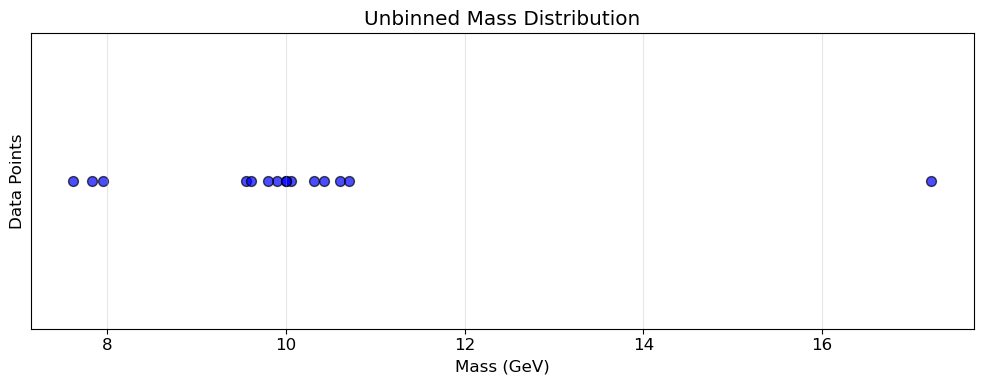

In [3]:
# Part (a) - Unbinned mass distribution
plt.figure(figsize=(10, 4))
plt.scatter(mass, np.ones(len(mass)), alpha=0.7, s=50, c='blue', edgecolors='black')
plt.ylim(0.5, 1.5)
plt.yticks([])
plt.xlabel('Mass (GeV)')
plt.ylabel('Data Points')
plt.title('Unbinned Mass Distribution')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

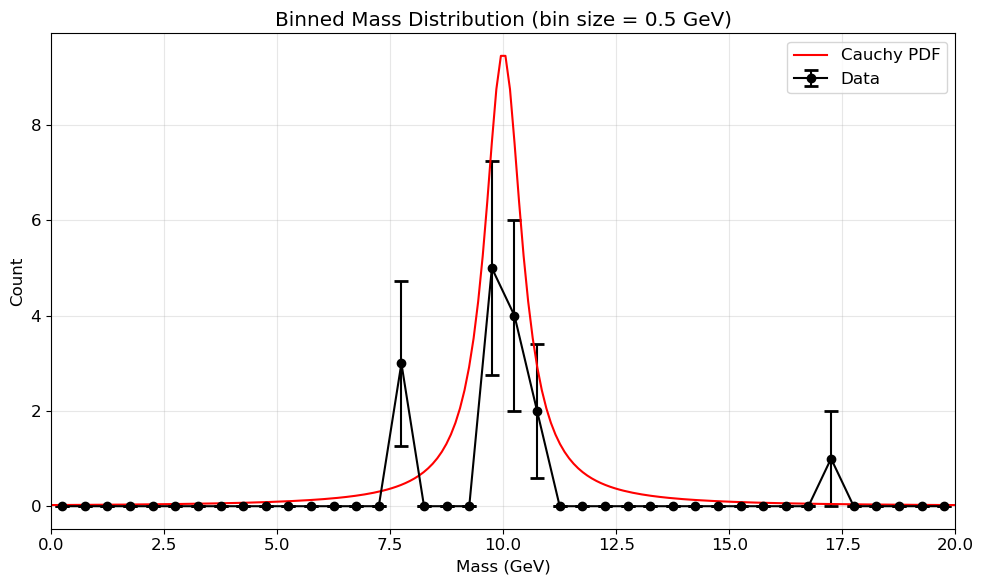

Total counts: 15
Non-zero bins: 5


In [16]:
from scipy.stats import cauchy

# Part (b) - Binned distribution with error bars
# Define bins
bin_edges = np.arange(0, 20.5, 0.5)  # 0 to 20 GeV with 0.5 GeV bins
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Create histogram
counts, _ = np.histogram(mass, bins=bin_edges)
errors = np.sqrt(counts)  # Poisson errors

plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, counts, yerr=errors, fmt='ko-', capsize=5, 
             capthick=2, markersize=6, linewidth=1.5, label='Data')
x = np.linspace(0,20,200)
p = 15*cauchy.pdf(x, loc=10, scale=0.5)
plt.plot(x, p, 'r-', label='Cauchy PDF')
plt.xlabel('Mass (GeV)')
plt.ylabel('Count')
plt.title('Binned Mass Distribution (bin size = 0.5 GeV)')
plt.xlim(0, 20)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total counts: {counts.sum()}")
print(f"Non-zero bins: {np.sum(counts > 0)}")

# Task 2: Maximum Likelihood Estimation (4 points)

In [5]:
# Part (a) - Negative log-likelihood function
import math


def negative_log_likelihood(loc, scale):
    """
    Calculate -2*log(L) for Cauchy distribution
    
    Parameters:
    params: [loc, scale] - location and scale parameters
    data: array of mass measurements
    
    Returns:
    -2*log(L): negative log-likelihood
    """
    
    # Calculate log-likelihood for all masses using Cauchy distribution 
    log_likelihood = np.sum(stats.cauchy.logpdf(mass, loc=loc, scale=scale))
     
    # Return -2*log(L)
    return -2 * log_likelihood

# stats.cauchy.logpdf
def pdf(x, mass, gamma):
    return (gamma/2)/((x-mass)**2+(gamma/2)**2)/math.pi


Test NLL value: 55.56
NLL at [9, 0.5]: 73.36
NLL at [11, 2]: 72.04


In [6]:
# Part (b) - Grid search for minimum NLL
# Define parameter ranges based on data
mass_range = np.linspace(9.5,10.5,201) # OR np.linspace(8, 12, 100)  Around mean of data
width_range = np.linspace(0.1, 2,201) # OR np.linspace(0.1, 3, 100)  Reasonable width range

# Create parameter grids
mass_grid, width_grid = np.meshgrid(mass_range, width_range)

# Calculate NLL for each parameter combination
nll_grid = np.zeros_like(mass_grid)

print("Scanning parameter space...")
for i in range(len(mass_range)):
    for j in range(len(width_range)):
        nll_grid[j, i] = negative_log_likelihood(mass_range[i], width_range[j]) 

##### GRADING: nll_grid = logL.T

# Find minimum
min_idx = np.unravel_index(np.argmin(nll_grid), nll_grid.shape)
best_mass = mass_range[min_idx[1]]
best_width = width_range[min_idx[0]]
min_nll = nll_grid[min_idx]

print('\nTrue Mass: 10 GeV')
print('True Width: 0.5 GeV ')


print(f"\nBest-fit parameters from grid search:")
print(f"Mass (m₀): {best_mass:.3f} GeV")
print(f"Width (Γ₀): {best_width:.3f} GeV")
print(f"Minimum -2logL: {min_nll:.2f}")

def objective(params):
    loc, scale = params
    return negative_log_likelihood(loc, scale)
# Verify with scipy optimization
result = minimize(objective, [best_mass, best_width], 
                 method='Nelder-Mead')
print(f"\nScipy optimization verification:")
print(f"Mass: {result.x[0]:.3f} GeV")
print(f"Width: {result.x[1]:.3f} GeV")
print(f"NLL: {result.fun:.2f}")

Scanning parameter space...

Best-fit parameters from grid search:
Mass (m₀): 9.980 GeV
Width (Γ₀): 0.422 GeV
Minimum -2logL: 50.29

Scipy optimization verification:
Mass: 9.993 GeV
Width: 0.409 GeV
NLL: 50.28


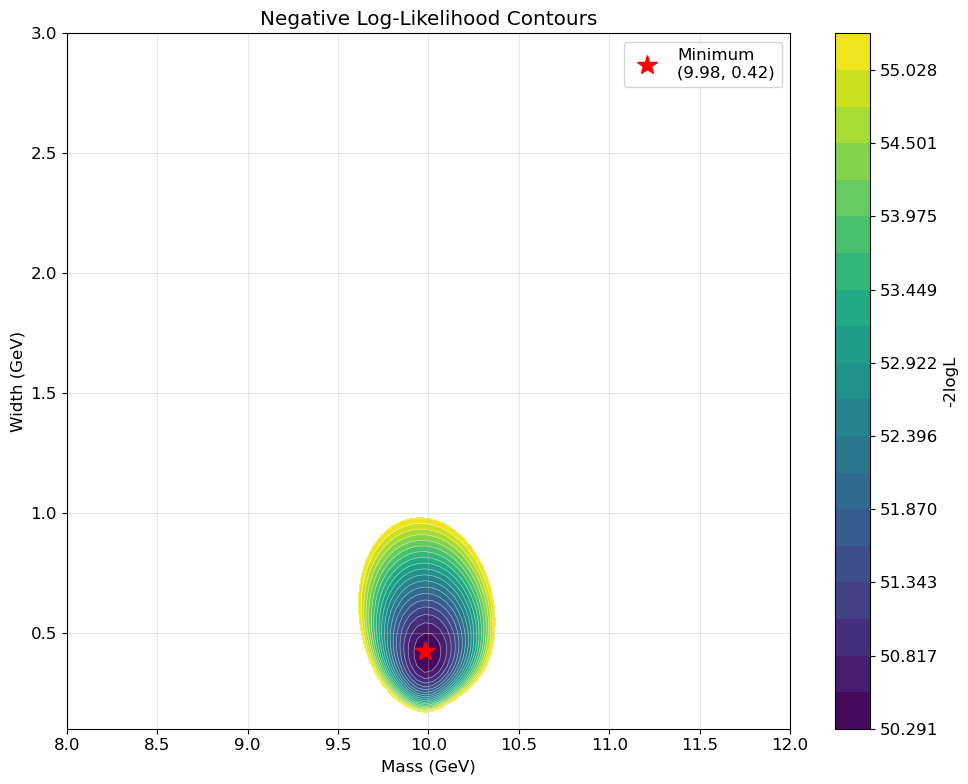

In [7]:
# Part (c) - 2D contour plot of NLL with centered minimum with centered minimum
plt.figure(figsize=(12, 10))

# Create filled contour plot
cs = plt.contourf(mass_grid, width_grid, nll_grid, levels=20, cmap='viridis')
plt.colorbar(cs, label='-2logL')

# Add contour lines for better visualization
cs_lines = plt.contour(mass_grid, width_grid, nll_grid, levels=20, 
                      colors='white', alpha=0.5, linewidths=0.5)

# Mark the minimum point
plt.plot(best_mass, best_width, 'r*', markersize=15, 
         label=f'Minimum\n({best_mass:.2f}, {best_width:.2f})')
plt.text(best_mass, best_width + 0.05, f'min NLL {min_nll:.2f}', 
         ha='center', fontsize=10, color='white', weight='bold')

plt.xlabel('Mass (GeV)')
plt.ylabel('Width (GeV)')
plt.title('Negative Log-Likelihood Contours')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Simple contour plot with labels
fig, ax = plt.subplots(figsize=(10, 8))
CS = ax.contour(mass_grid, width_grid, nll_grid, levels=15)
ax.clabel(CS, inline=True, fontsize=8)
ax.set_xlabel('Mass (GeV)')
ax.set_ylabel('Width (GeV)')
ax.set_title('NLL Contours with Labels')
ax.plot(best_mass, best_width, marker="o", markersize=8, 
        markeredgecolor="red", markerfacecolor="red")
ax.text(best_mass, best_width + 0.05, f'min NLL {min_nll:.2f}', 
        ha='center', fontsize=10, color='red', weight='bold')
plt.grid(True, alpha=0.3)
plt.show()

# 3D surface plot
fig = plt.figure(figsize=(14, 9))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(mass_grid, width_grid, nll_grid, cmap='viridis', alpha=0.8)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='-2logL')

# Mark minimum point in 3D
ax.scatter([best_mass], [best_width], [min_nll], color='red', s=100, 
           label=f'Minimum ({best_mass:.2f}, {best_width:.2f})')

ax.set_xlabel('Mass (GeV)')
ax.set_ylabel('Width (GeV)')
ax.set_zlabel('-2logL')
ax.set_title('3D NLL Surface')
ax.view_init(30, -50)
ax.legend()
plt.show()

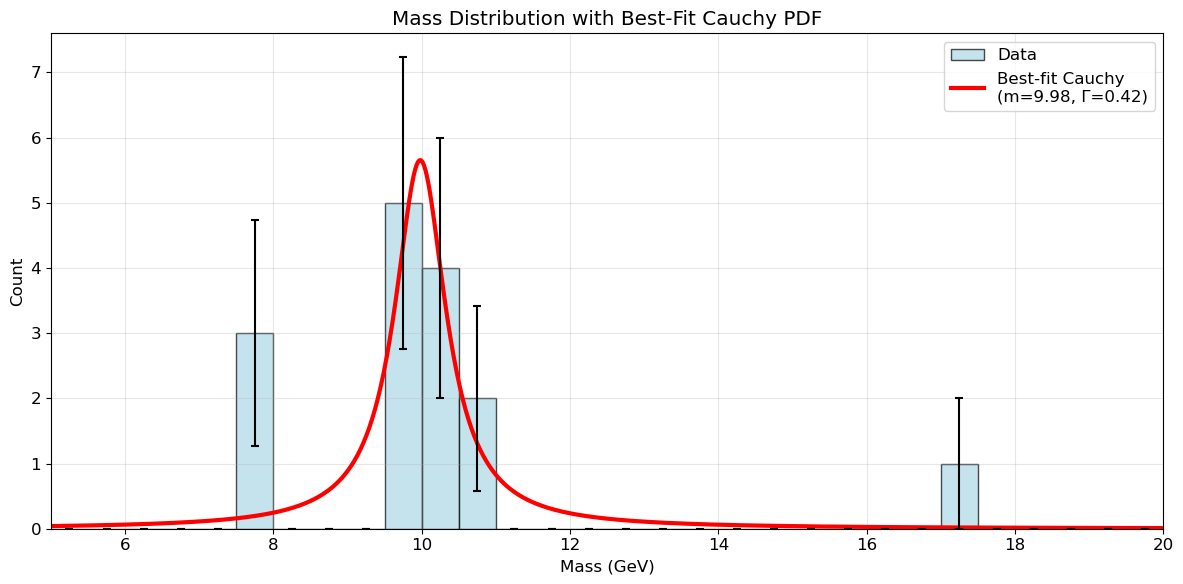

Goodness of fit: χ² = 90.62, DOF = 3, χ²/DOF = 30.21


In [8]:
# Part (d) - Plot data with best-fit PDF
plt.figure(figsize=(12, 6))

# Plot histogram of data
counts_plot, bins_plot, _ = plt.hist(mass, bins=bin_edges, alpha=0.7, color='lightblue', 
                                    edgecolor='black', label='Data')

# Create smooth curve for theoretical PDF
x_theory = np.linspace(0, 20, 1000)
pdf_theory = cauchy.pdf(x_theory, loc=best_mass, scale=best_width)

# Scale PDF to match histogram (multiply by bin width and total counts)
bin_width = bin_edges[1] - bin_edges[0]
pdf_scaled = pdf_theory * len(mass) * bin_width

plt.plot(x_theory, pdf_scaled, 'r-', linewidth=3, 
         label=f'Best-fit Cauchy\n(m={best_mass:.2f}, Γ={best_width:.2f})')

# Add error bars on data points
bin_centers_plot = (bins_plot[:-1] + bins_plot[1:]) / 2
errors_plot = np.sqrt(counts_plot)
plt.errorbar(bin_centers_plot, counts_plot, yerr=errors_plot, fmt='none', 
             color='black', capsize=3, capthick=1.5)

plt.xlabel('Mass (GeV)')
plt.ylabel('Count')
plt.title('Mass Distribution with Best-Fit Cauchy PDF')
plt.xlim(5, 20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate goodness of fit
expected_counts = []
for i in range(len(bin_edges)-1):
    prob = stats.cauchy.cdf(bin_edges[i+1], loc=best_mass, scale=best_width) - \
           stats.cauchy.cdf(bin_edges[i], loc=best_mass, scale=best_width)
    expected_counts.append(prob * len(mass))

expected_counts = np.array(expected_counts)
observed_counts = counts

# Calculate chi-squared for non-zero bins
nonzero_mask = observed_counts > 0
chi2 = np.sum((observed_counts[nonzero_mask] - expected_counts[nonzero_mask])**2 / 
              expected_counts[nonzero_mask])
dof = np.sum(nonzero_mask) - 2  # 2 fitted parameters

print(f"Goodness of fit: χ² = {chi2:.2f}, DOF = {dof}, χ²/DOF = {chi2/dof:.2f}")

# Task 3: Maximum Likelihood vs Chi-squared Method (3 points)

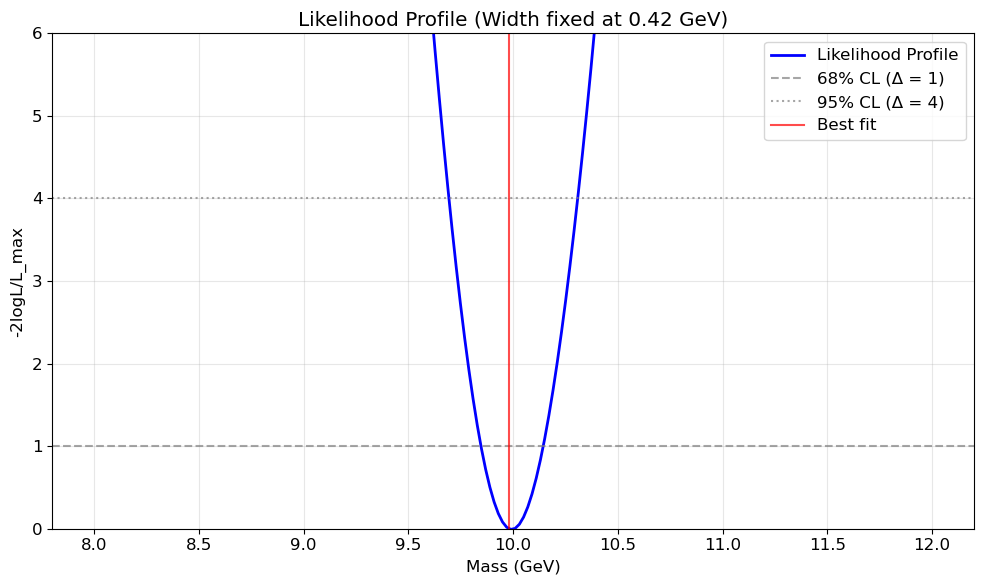

In [9]:
# Part (a) - Likelihood profile with fixed width
# Fix width to best-fit value
fixed_width = best_width

# Scan mass parameter
mass_scan = np.linspace(8, 12, 200)
nll_profile = []

for m in mass_scan:
    nll = negative_log_likelihood(m, fixed_width)
    nll_profile.append(nll)

nll_profile = np.array(nll_profile)

# Normalize by minimum
nll_normalized = nll_profile - min_nll

plt.figure(figsize=(10, 6))
plt.plot(mass_scan, nll_normalized, 'b-', linewidth=2, label='Likelihood Profile')
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='68% CL (Δ = 1)')
plt.axhline(y=4, color='gray', linestyle=':', alpha=0.7, label='95% CL (Δ = 4)')
plt.axvline(x=best_mass, color='red', linestyle='-', alpha=0.7, label='Best fit')

plt.xlabel('Mass (GeV)')
plt.ylabel('-2logL/L_max')
plt.title(f'Likelihood Profile (Width fixed at {fixed_width:.2f} GeV)')
plt.ylim(0, 6)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Part (b) - Chi-squared method
def chi_squared(mass_param, width_param, data, bin_edges):
    """
    Calculate chi-squared for binned data
    """
    # Get observed counts
    observed, _ = np.histogram(data, bins=bin_edges)
    
    # Calculate expected counts from Cauchy distribution
    expected = []
    for i in range(len(bin_edges)-1):
        prob = stats.cauchy.cdf(bin_edges[i+1], loc=mass_param, scale=width_param) - \
               stats.cauchy.cdf(bin_edges[i], loc=mass_param, scale=width_param)
        expected.append(prob * len(data))
    
    expected = np.array(expected)
    
    # Calculate chi-squared (use observed counts as variance estimate)
    # Only include bins with at least 1 count to avoid division by zero
    mask = observed > 0
    chi2 = np.sum((observed[mask] - expected[mask])**2 / observed[mask])
    
    return chi2

# Scan mass parameter for chi-squared (fix width)
chi2_values = []
for m in mass_scan:
    chi2 = chi_squared(m, fixed_width, mass, bin_edges)
    chi2_values.append(chi2)

chi2_values = np.array(chi2_values)
min_chi2 = np.min(chi2_values)
delta_chi2 = chi2_values - min_chi2
best_mass_chi2 = mass_scan[np.argmin(chi2_values)]

print(f"Chi-squared method results:")
print(f"Best-fit mass: {best_mass_chi2:.3f} GeV")
print(f"Minimum chi-squared: {min_chi2:.2f}")
print(f"DOF: {np.sum(counts > 0) - 1}")

Chi-squared method results:
Best-fit mass: 9.970 GeV
Minimum chi-squared: 3.87
DOF: 4


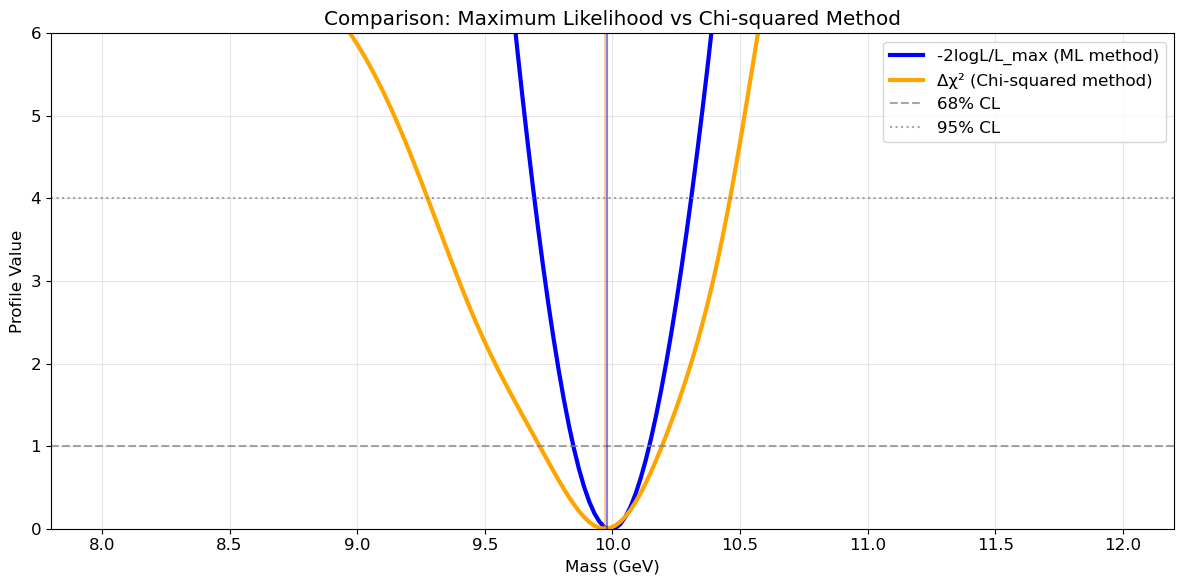


Observations:
1. ML best-fit mass: 9.980 GeV
2. Chi² best-fit mass: 9.970 GeV
3. Difference: 0.010 GeV
4. Both methods show similar parabolic shape near minimum
5. ML method uses all information (unbinned), while Chi² uses binned data
6. ML method is generally more precise for small datasets


In [11]:
# Part (c) - Compare both methods
plt.figure(figsize=(12, 6))

# Plot both curves
plt.plot(mass_scan, nll_normalized, 'b-', linewidth=3, label='-2logL/L_max (ML method)')
plt.plot(mass_scan, delta_chi2, 'orange', linewidth=3, label='Δχ² (Chi-squared method)')

# Add reference lines
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='68% CL')
plt.axhline(y=4, color='gray', linestyle=':', alpha=0.7, label='95% CL')

# Mark minima
plt.axvline(x=best_mass, color='blue', linestyle='-', alpha=0.5)
plt.axvline(x=best_mass_chi2, color='orange', linestyle='-', alpha=0.5)

plt.xlabel('Mass (GeV)')
plt.ylabel('Profile Value')
plt.title('Comparison: Maximum Likelihood vs Chi-squared Method')
plt.ylim(0, 6)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservations:")
print(f"1. ML best-fit mass: {best_mass:.3f} GeV")
print(f"2. Chi² best-fit mass: {best_mass_chi2:.3f} GeV")
print(f"3. Difference: {abs(best_mass - best_mass_chi2):.3f} GeV")
print(f"4. Both methods show similar parabolic shape near minimum")
print(f"5. ML method uses all information (unbinned), while Chi² uses binned data")
print(f"6. ML method is generally more precise for small datasets")

# Bonus: Using iminuit Package (3 points)

In [12]:
# Install and import iminuit
try:
    from iminuit import Minuit
    from iminuit.cost import UnbinnedNLL
    print("iminuit imported successfully!")
    IMINUIT_AVAILABLE = True
except ImportError:
    print("Installing iminuit...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "iminuit"])
    from iminuit import Minuit
    from iminuit.cost import UnbinnedNLL
    IMINUIT_AVAILABLE = True

Installing iminuit...


In [13]:
# iminuit implementation
if IMINUIT_AVAILABLE:
    # Define Cauchy distribution for iminuit
    def cauchy_pdf(x, loc, scale):
        """Cauchy PDF for iminuait"""
        return stats.cauchy.pdf(x, loc=loc, scale=scale)
    
    # Set up unbinned negative log-likelihood
    nll_cost = UnbinnedNLL(mass, cauchy_pdf)
    
    # Create Minuit object with initial parameter guesses
    m = Minuit(nll_cost, loc=10.0, scale=1.0)
    
    # Set parameter limits
    m.limits['scale'] = (0.001, None)  # Scale must be positive
    
    # Run the fit
    m.migrad()  # Main minimization
    m.hesse()   # Calculate parameter errors
    
    print("=" * 50)
    print("IMINUIT FIT RESULTS")
    print("=" * 50)
    print(f"Function minimum: {m.fval:.2f}")
    print(f"Fit converged: {m.valid}")
    print(f"\nParameters:")
    for param, value, error in zip(m.parameters, m.values, m.errors):
        print(f"  {param}: {value:.4f} ± {error:.4f}")
    
    # Display full fit information
    print(f"\nDetailed results:")
    print(m)
    
    # Extract results
    iminuit_mass = m.values['loc']
    iminuit_width = m.values['scale']
    iminuit_mass_err = m.errors['loc']
    iminuit_width_err = m.errors['scale']
    
    print(f"\nSummary:")
    print(f"Mass: {iminuit_mass:.3f} ± {iminuit_mass_err:.3f} GeV")
    print(f"Width: {iminuit_width:.3f} ± {iminuit_width_err:.3f} GeV")
    print(f"NLL: {m.fval:.2f}")
else:
    print("iminuit not available")

IMINUIT FIT RESULTS
Function minimum: 50.28
Fit converged: True

Parameters:
  loc: 9.9935 ± 0.1432
  scale: 0.4097 ± 0.1561

Detailed results:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 50.28                      │              Nfcn = 72               │
│ EDM = 1.16e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└───────────────────

COMPARISON OF FITTING METHODS
Method               Mass (GeV)      Width (GeV)     NLL       
------------------------------------------------------------
Manual Grid Search   9.980           0.422           50.29     
Scipy Minimize       9.993           0.409           50.28     
iminuit              9.993           0.410           50.28     

Parameter uncertainties (iminuit only):
Mass error: ±0.143 GeV
Width error: ±0.156 GeV

Consistency check:
Mass difference (grid vs iminuit): 0.0137 GeV
Width difference (grid vs iminuit): 0.0126 GeV
⚠ Methods show some differences - check grid resolution

Parameter correlation:
Correlation(mass, width): 0.028


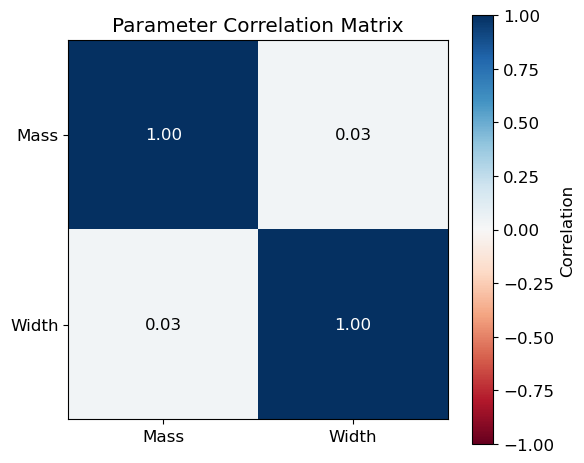

In [14]:
# Compare all fitting methods
if IMINUIT_AVAILABLE:
    print("=" * 60)
    print("COMPARISON OF FITTING METHODS")
    print("=" * 60)
    
    print(f"{'Metidth:<15.3f} {min_nll:<10.2f}")
    print(f"{'Scipy Minimize':<20} {result.x[0]:<15.3f} {result.x[1]:<15.3f} {result.fun:<10.2f}")
    print(f"{'iminuit':<20} {iminuit_mass:<15.3f} {iminuit_width:<15.3f} {m.fval:<10.2f}")
    
    print(f"\nParameter uncertainties (iminuit only):")
    print(f"Mass error: ±{iminuit_mass_err:.3f} GeV")
    print(f"Width error: ±{iminuit_width_err:.3f} GeV")
    
    print(f"\nConsistency check:")
    mass_diff = abs(best_mass - iminuit_mass)
    width_diff = abs(best_width - iminuit_width)
    print(f"Mass difference (grid vs iminuit): {mass_diff:.4f} GeV")
    print(f"Width difference (grid vs iminuit): {width_diff:.4f} GeV")
    
    if mass_diff < 0.01 and width_diff < 0.01:
        print("✓ All methods agree within 0.01 GeV - Good consistency!")
    else:
        print("⚠ Methods show some differences - check grid resolution")
    
    # Plot correlation matrix if available
    if hasattr(m, 'covariance'):
        print(f"\nParameter correlation:")
        corr = m.covariance.correlation()
        print(f"Correlation(mass, width): {corr[0,1]:.3f}")
        
        # Simple correlation plot
        plt.figure(figsize=(6, 5))
        plt.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)
        plt.colorbar(label='Correlation')
        plt.xticks([0, 1], ['Mass', 'Width'])
        plt.yticks([0, 1], ['Mass', 'Width'])
        plt.title('Parameter Correlation Matrix')
        
        # Add correlation values
        for i in range(2):
            for j in range(2):
                plt.text(j, i, f'{corr[i,j]:.2f}', ha='center', va='center', 
                        color='white' if abs(corr[i,j]) > 0.5 else 'black')
        
        plt.tight_layout()
        plt.show()

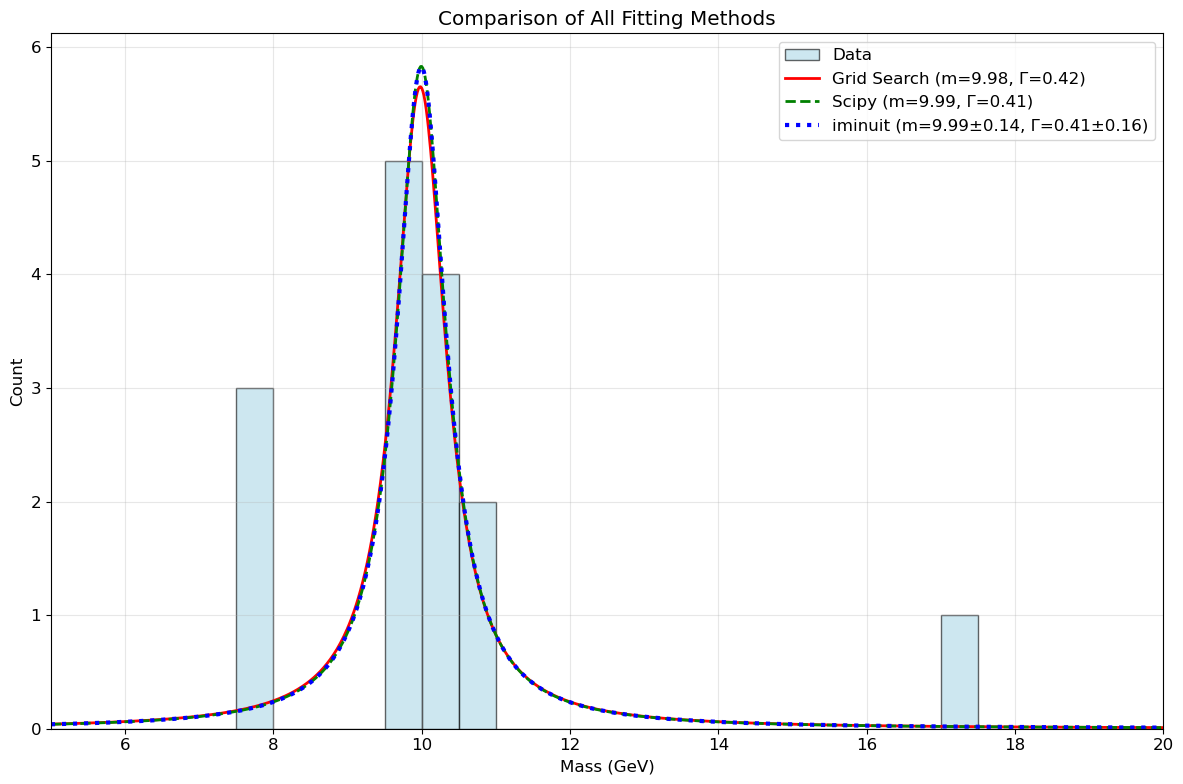


LAB 4 SOLUTION COMPLETE
Key learning outcomes:
✓ Maximum likelihood estimation for continuous distributions
✓ Parameter scanning and optimization techniques
✓ Comparison of ML and chi-squared methods
✓ Professional fitting with iminuit package
✓ Parameter uncertainty estimation
✓ Goodness-of-fit evaluation


In [15]:
# Discussion and Analysis

**Answer the following questions based on your results:**


## Task 2 Discussion: Maximum Likelihood Estimation

**Question 2:** Analyze your NLL contour plots and parameter estimation results. What does the shape of the contours tell you about parameter correlations? How sensitive is the fit to small changes in the mass and width parameters? Compare your best-fit parameters to your initial theoretical prediction from Task 1.

**Your Answer:**

---

## Task 3 Discussion: Method Comparison

**Question 3:** Compare the likelihood profile and chi-squared methods. Which method gave a more precise estimate of the mass parameter? How do the shapes of the two curves differ near the minimum? Explain why the maximum likelihood method is generally preferred for small datasets like ours (15 data points).

**Your Answer:**

---

## Model Comparison and Overall Analysis

**Question 4:** Compare all the fitting approaches you used (manual grid search, scipy optimization, and iminuit if completed). Did they all converge to the same parameter values? Which method was most efficient? Which provided the most complete uncertainty information?

**Your Answer:**
# Final comparison plot with all methods
plt.figure(figsize=(12, 8))

# Plot the data
plt.hist(mass, bins=bin_edges, alpha=0.6, color='lightblue', edgecolor='black', 
         label='Data', density=False)

# Plot PDF curves from different methods
x_fine = np.linspace(5, 20, 1000)

# Grid search result
pdf_grid = stats.cauchy.pdf(x_fine, loc=best_mass, scale=best_width)
plt.plot(x_fine, pdf_grid * len(mass) * bin_width, 'r-', linewidth=2, 
         label=f'Grid Search (m={best_mass:.2f}, Γ={best_width:.2f})')

# Scipy result
pdf_scipy = stats.cauchy.pdf(x_fine, loc=result.x[0], scale=result.x[1])
plt.plot(x_fine, pdf_scipy * len(mass) * bin_width, 'g--', linewidth=2,
         label=f'Scipy (m={result.x[0]:.2f}, Γ={result.x[1]:.2f})')

if IMINUIT_AVAILABLE:
    # iminuit result
    pdf_iminuit = stats.cauchy.pdf(x_fine, loc=iminuit_mass, scale=iminuit_width)
    plt.plot(x_fine, pdf_iminuit * len(mass) * bin_width, 'b:', linewidth=3,
             label=f'iminuit (m={iminuit_mass:.2f}±{iminuit_mass_err:.2f}, Γ={iminuit_width:.2f}±{iminuit_width_err:.2f})')

plt.xlabel('Mass (GeV)')
plt.ylabel('Count')
plt.title('Comparison of All Fitting Methods')
plt.xlim(5, 20)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("LAB 4 SOLUTION COMPLETE")
print("="*60)
print("Key learning outcomes:")
print("✓ Maximum likelihood estimation for continuous distributions")
print("✓ Parameter scanning and optimization techniques")
print("✓ Comparison of ML and chi-squared methods")
print("✓ Professional fitting with iminuit package")
print("✓ Parameter uncertainty estimation")
print("✓ Goodness-of-fit evaluation")

# Discussion and Analysis

**Answer the following questions based on your results:**


## Task 2 Discussion: Maximum Likelihood Estimation

**Question 1:** Analyze your NLL contour plots and parameter estimation results. What does the shape of the contours tell you about parameter correlations? How sensitive is the fit to small changes in the mass and width parameters? Compare your best-fit parameters to your initial theoretical prediction from Task 1.

**Your Answer:**

---

## Task 3 Discussion: Method Comparison

**Question 2:** Compare the likelihood profile and chi-squared methods. Which method gave a more precise estimate of the mass parameter? How do the shapes of the two curves differ near the minimum? Explain why the maximum likelihood method is generally preferred for small datasets like ours (15 data points).

**Your Answer:**

---

## Model Comparison and Overall Analysis

**Question 3:** Compare all the fitting approaches you used (manual grid search, scipy optimization, and iminuit if completed). Did they all converge to the same parameter values? Which method was most efficient? Which provided the most complete uncertainty information?

**Your Answer:**
